In [1]:
import pandas as pd
import numpy as np
import re


from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.viz import word_plot

sns.set()

In [26]:
content_based = pd.read_csv('./data/desc_filtered_genre.csv')
movie_df = content_based.copy()
content_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67935 entries, 0 to 67934
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        67935 non-null  object
 1   description  67935 non-null  object
 2   title        67935 non-null  object
 3   starring     67935 non-null  object
 4   movie_id     67935 non-null  object
dtypes: object(5)
memory usage: 2.6+ MB


In [3]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [4]:
sw = stopwords.words('english')

tokenizer = RegexpTokenizer('\w+')

lemmer = WordNetLemmatizer()

regex_template = r"[^\w\s]"

In [5]:
def preprocess_and_lemmatize(text):
    text = re.sub(regex_template, '', text)
    
    text = text.lower()

    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]

    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    
    return ' '.join(lemmatized_words)


In [6]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return words


In [7]:
def remove_sw(text):
    
    words = text

    words = [word for word in words if word not in sw]
    
    return words

In [8]:
content_based['description'] = content_based['description'].apply(preprocess_and_lemmatize)
content_based.head()

,genre,description,title,starring,movie_id
0,Faith & Spirituality,angel show dumitru california la vegas new yor...,A Call to Holiness VHS,Michael Boldea,0001421409
1,Documentary,documentary film life st faustina 34run whole ...,The Life of Sister Faustina: The Apostle of Di...,Sr. Faustina,0001485423
2,Documentary,documentary take journeyfrom christopher colum...,A NATION ADRIFT A Chronicle of America's Prov...,Tom Kane,0005092663
3,Kids & Family,18 music video kid ear hang low wise man fooli...,Cedarmont Kids Silly Songs: 18 Wholesome Fun S...,Various Artists,0005123909
4,Documentary,comprehensive documentary ufos ever produce re...,UFOs : The Hidden Truth VHS,Brian Barkley,0005445825


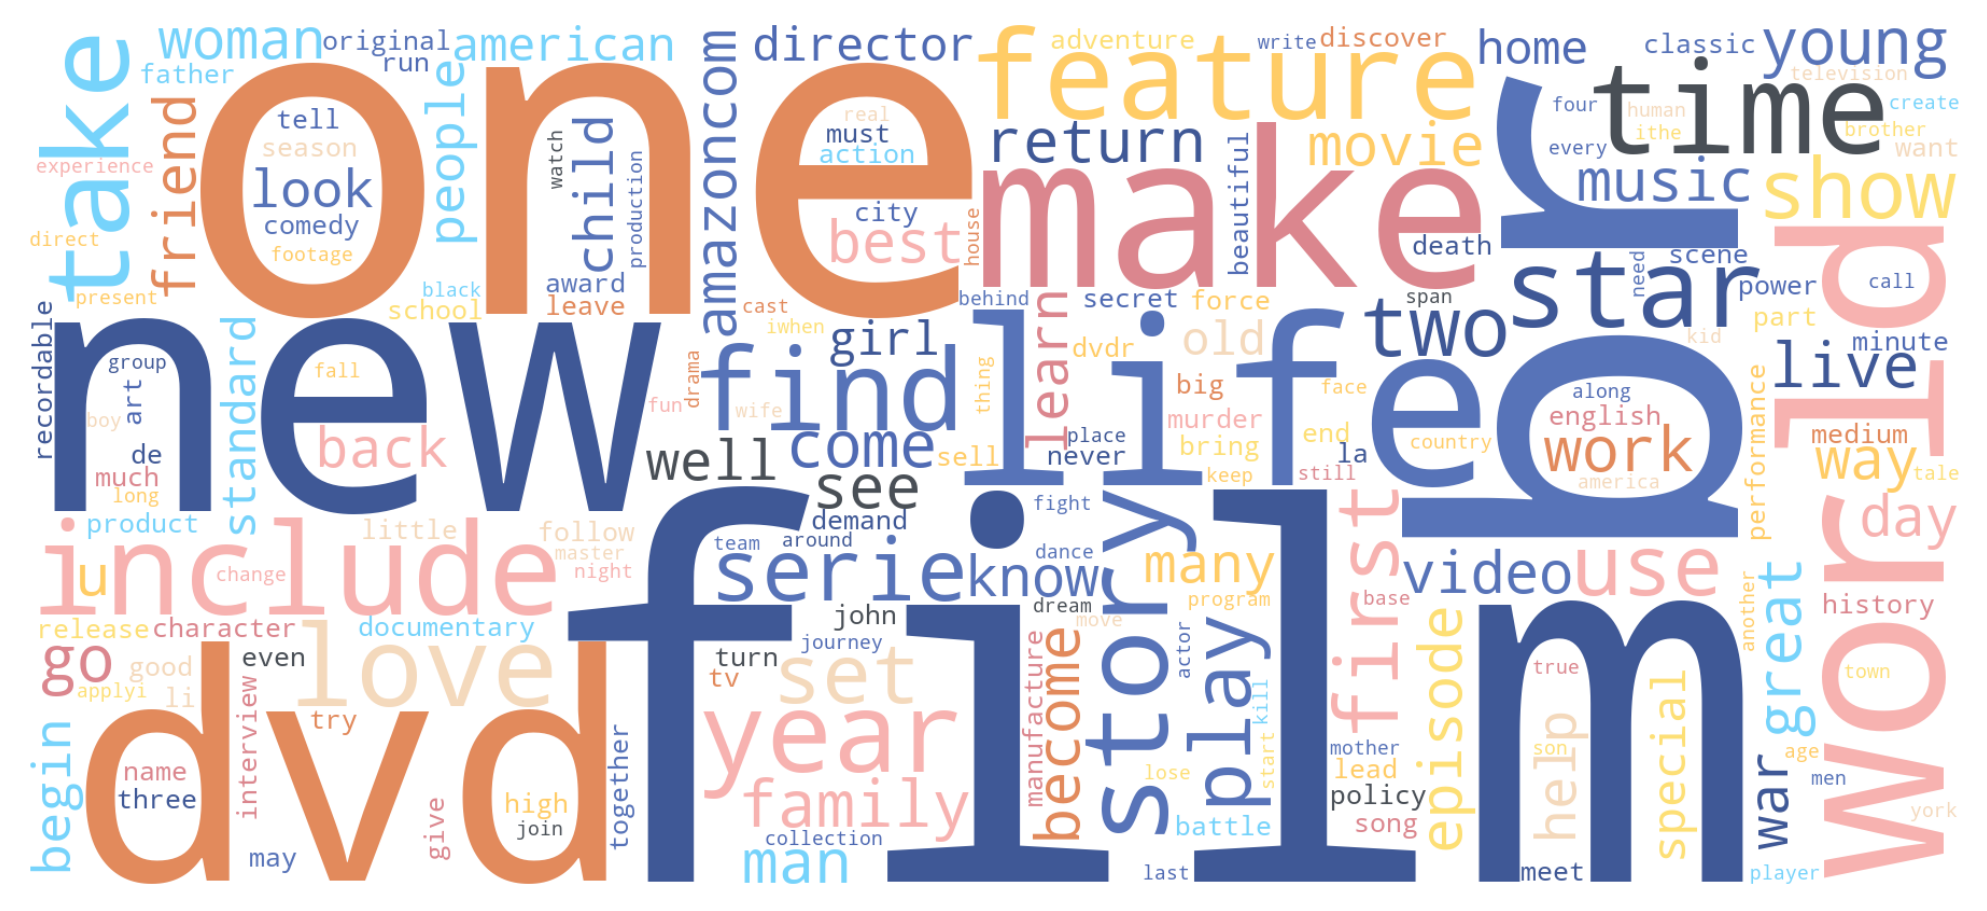

In [9]:
# This is the palette used in our associated
# presentation, available at a link later on
raw_map = [
        '#3f5896', '#494f56', '#4f6ab3',
        '#5773b8', '#76d3fb', '#db868e',
        '#e28a5c', '#f4d9bc', '#f7b2b0',
        '#fddf75', '#ffcc66'
        ]
canvamap = ListedColormap(raw_map)

wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='#ffffff'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
content_based['description'] = content_based['description'].apply(tokenize_sw)

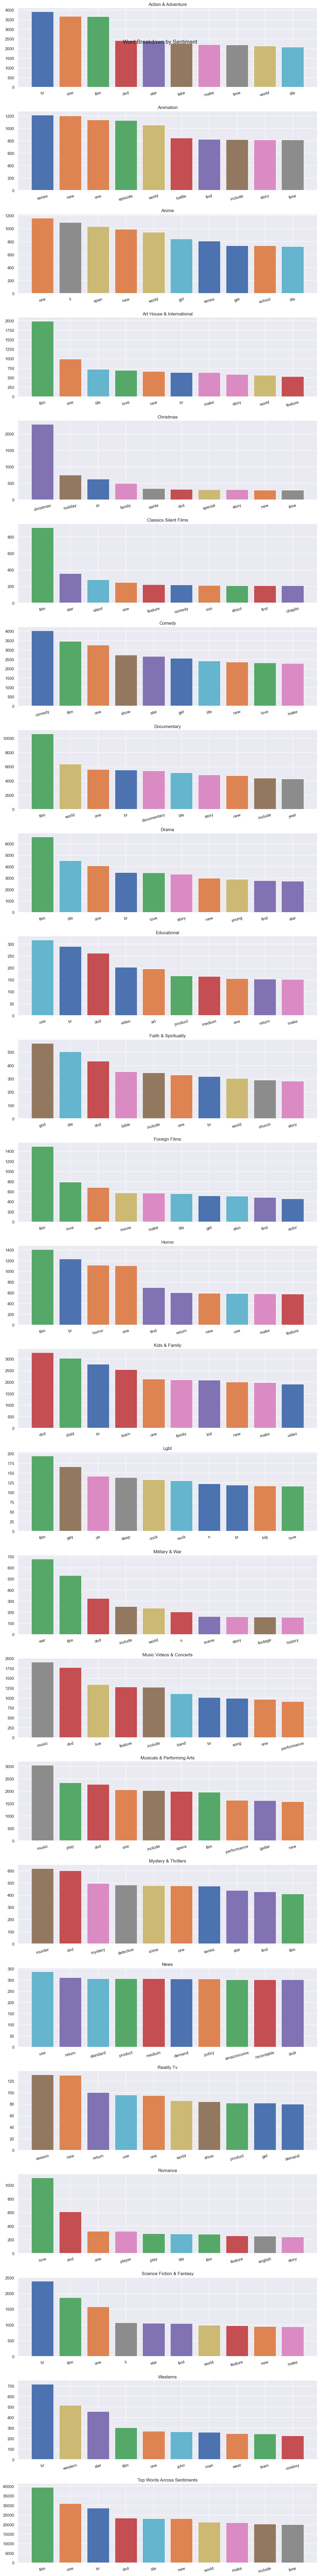

In [11]:
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10)

In [12]:
sw = stopwords.words('english')
specific_words = [
    'film','one','br', 'movie',
    'new', 'dvd', 'DVD', 'love',
    'life'
]

sw.extend(specific_words)

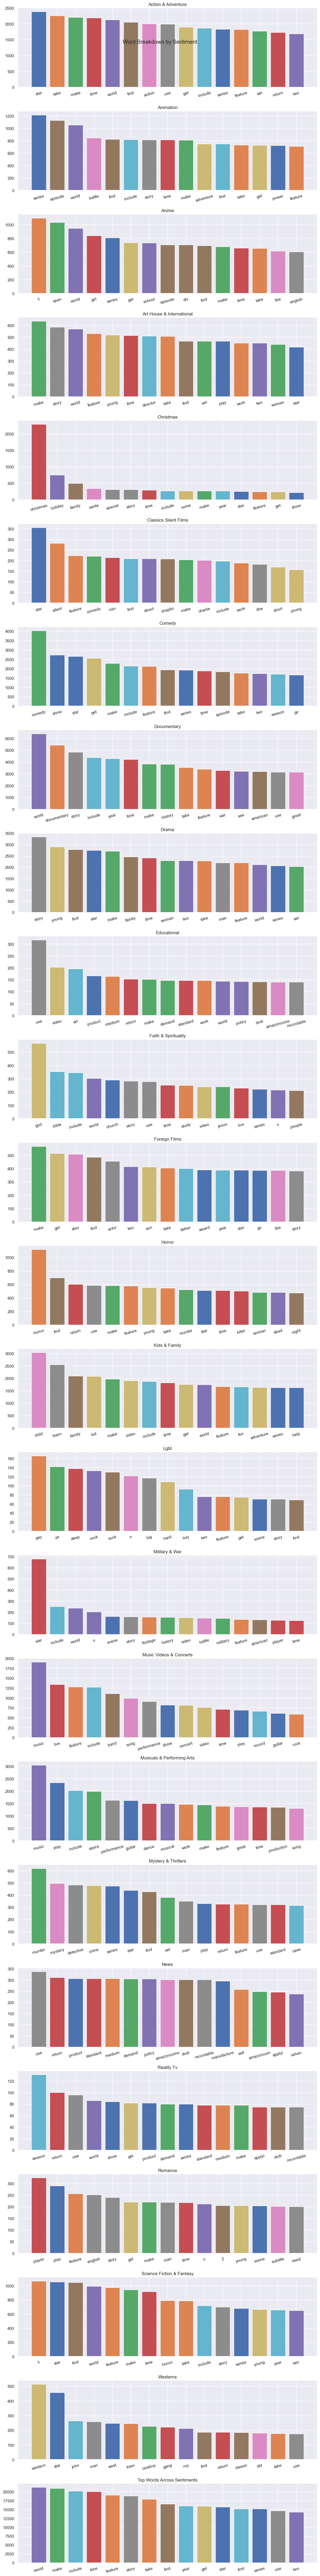

In [13]:
content_based['description'] = content_based['description'].apply(remove_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=15)

In [14]:
sw = sw.copy()

more_words = [
    'world', 'story', 'feature', 'time',
    'make', 'get'
    ]
sw.extend(more_words)

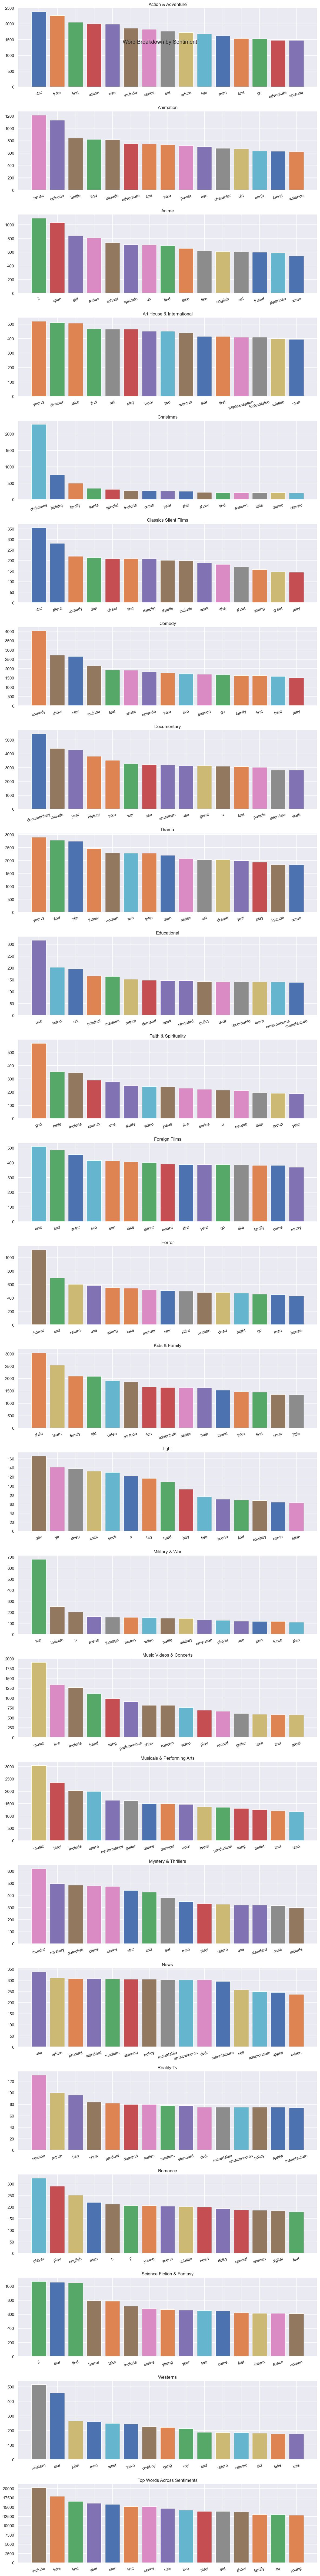

In [15]:
content_based['description'] = content_based['description'].apply(remove_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=15)

In [16]:
content_based.set_index('movie_id', inplace=True)
content_based.drop(columns=['title', 'starring'], inplace=True)
content_based['description'] = content_based['description'].apply(lambda x: ' '.join(x))
content_based = pd.get_dummies(content_based, columns=['genre'], dtype=int)

In [17]:
vectorizer = TfidfVectorizer(max_features=460)
tf_genre = vectorizer.fit_transform(content_based['description'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vectorizer.get_feature_names_out(), index=content_based.index)

tf_genre = pd.concat([content_based.drop(['description'], axis=1), tf_genre], axis=1)
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67935 entries, 0001421409 to B01HJCCLOY
Columns: 484 entries, genre_Action & Adventure to young
dtypes: float64(460), int32(24)
memory usage: 245.2+ MB


In [38]:
def cos_recs_genre(movie_id):
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]
    
    cosine_matrix = cosine_similarity(tf_genre)
    
    similarity_scores = pd.Series(cosine_matrix[tf_genre.index.get_loc(movie_id)], index=tf_genre.index)
    
    sorted_scores = similarity_scores.sort_values(ascending=False)
    
    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)
    
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations.index), ['title', 'genre', 'starring', 'movie_id']]
    
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    print("\nRecommended movies:")
    return recommended_movies

In [39]:
def knn_recs_genre(movie_id):
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]

    features = tf_genre

    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(features.values)

    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    top_recommendations = [tf_genre.index[i] for i in indices[0][1:]]
    
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations), ['title', 'genre', 'starring','movie_id']]

    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    print("\nRecommended movies:")
    return recommended_movies

In [40]:
cosine_recommendations_genre = cos_recs_genre('0307142493')
cosine_recommendations_genre

Input movie information:
                            title     genre     starring
Santa Claus Is Comin' To Town VHS Animation Fred Astaire

Recommended movies:


,title,genre,starring,movie_id
1240,The Stingiest Man in Town VHS,Animation,Walter Matthau,6301760379
20621,"Bah, Humduck! A Looney Tunes Christmas",Animation,Charles Visser,B000HC2LH6
20812,The Night Before Christmas: A Mouse Tale,Animation,Various Artists,B000HLDFLS
26883,Care Bears 25th Anniversary Gift Set,Animation,Dan Hennessey,B000VKKV3A
40891,The Wheels on the Bus... and More Musical Stories,Animation,Various Artists,B0039ZBM78


In [41]:
knn_recommendations_genre = knn_recs_genre('0307142493')
knn_recommendations_genre

Input movie information:
                            title     genre     starring
Santa Claus Is Comin' To Town VHS Animation Fred Astaire

Recommended movies:


,title,genre,starring,movie_id
1240,The Stingiest Man in Town VHS,Animation,Walter Matthau,6301760379
20621,"Bah, Humduck! A Looney Tunes Christmas",Animation,Charles Visser,B000HC2LH6
20812,The Night Before Christmas: A Mouse Tale,Animation,Various Artists,B000HLDFLS
26883,Care Bears 25th Anniversary Gift Set,Animation,Dan Hennessey,B000VKKV3A
40891,The Wheels on the Bus... and More Musical Stories,Animation,Various Artists,B0039ZBM78
